<a href="https://colab.research.google.com/github/samanthasosome/GW-noise-ML-classification/blob/main/DENOISING_AE_MODEL_UP2007839.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### NOTEBOOK 2: DENOISING AUTOENCODER MODEL

In [1]:
pip install keras

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import numpy as np
import pandas as pd
import keras
from keras.models import Model
from keras.layers import Input, Dense
from matplotlib import pyplot as pyplot
from keras.callbacks import LearningRateScheduler
import zipfile
import importlib as imp
from keras.callbacks import EarlyStopping, ModelCheckpoint

import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score


import os
import numpy as np
from numpy.fft import rfft, irfft
import scipy.signal as sig

from functools import partial
rfft = partial(rfft, norm='ortho')
irfft = partial(irfft, norm='ortho')

In [3]:
def center(data):
    """Shift data from the start to the center of a time series"""
    return np.roll(data, len(data)//2)

def downsample_invasd(invasd, tlen=1024):
    """Reduce frequency resolution of the inverse ASD to a given number of time samples"""
    tmp = np.abs(rfft(sig.hann(tlen)*np.roll(irfft(invasd), tlen//2)[:tlen]))
    tmp[0] = 0.
    return tmp

def to_fd(data):
    """Convert to frequency domain with t=0 in center"""
    return rfft(np.roll(data, -len(data)//2))

def extract_glitch(npz, halfwidth=512):
    """Returns 1/4 second inverse ASD and 2 sec of whitened glich, @8192Hz"""
    invasd = ((4096.*npz['psd'])**-0.5)[:4097]
    invasd[:10] = 0.
    filt = np.zeros(4*8192)
    filt[:8192] = sig.hann(8192)*np.roll(irfft(invasd), 4096)
    fdfilt = np.abs(rfft(filt)) # This is a one-second resolution invasd

    whts = irfft(fdfilt*rfft(npz['data']))
    invasd_ds = downsample_invasd(invasd)

    return invasd_ds, whts[len(whts)//2 - halfwidth:len(whts)//2 + halfwidth],  whts

def snr(snip):
    tmp = np.zeros(4*8192)
    tmp[:len(snip.glitch)] = snip.glitch.copy()
    gt = TimeSeries(np.roll(tmp,-len(snip.glitch)//2), delta_t=1/8192)
    dt = TimeSeries(snip.whts_long, delta_t=1/8192)
    dt[:4096]=0.;dt[len(dt)-4096:]=0.;
    snrts = matched_filter(gt, dt, psd=FrequencySeries([1./4096]*(1+4*4906), delta_f=1/4.), low_frequency_cutoff=15)

    return np.abs(snrts[16384-2048:16384+2048]).max()

def measure(inf_data, snip):
    itrace = inf_data['mean']
    inf = {key: float(itrace[key])
            for key in ['amp_r', 'amp_i', 'f0','gbw','time']}
    strace = inf_data['sd']
    inf |= {key+'_sd': float(strace[key])
            for key in ['amp_r', 'amp_i', 'f0','gbw','time']}
    cpamp = inf['amp_r']+1.j*inf['amp_i']
    inf['amp'] = np.abs(cpamp)
    inf['phase'] = np.angle(cpamp)
    inf['time'] = inf['time']
    snip.set_infer(inf)
    inf['snr'] = snr(snip)
    inf['power'] = np.sum((snip.whts[256:768])**2)/512
    inf['residual'] = np.sum(((snip.whts-snip.glitch)[256:768])**2)/512
    inf['peak_frequency'] = float(freqs[(snip.invasd*np.abs(snip.fglitch)).argmax()])
    return inf, snip

class Snippet:
    """A class to load and whiten data, """
    def __init__(self, filename):
        #self.ifo, self.key, self.num = ifo, key, num
        npz = np.load(filename)
        self.invasd, self.whts, self.whts_long = extract_glitch(npz)
    def set_infer(self, inf):
        self.inf = inf



    def plot(self):
        myfreqs = np.linspace(0,4096,513)

        import matplotlib.pyplot as plt
        fig1 = plt.figure()
        #plt.title(f"{self.ifo} {self.key} {self.num}")
        plt.loglog(myfreqs, np.abs(rfft(self.whts)), c='k', lw=1)
        plt.ylim(1e-2,1e2)

        fig2 = plt.figure()
        #plt.title(f"{self.ifo} {self.key} {self.num}")
        plt.plot(self.whts, c='k', lw=1)


        return fig1, fig2

class SnippetNormed:
    """A class to load and whiten data, """
    def __init__(self, ifo, key, num):
        self.ifo, self.key, self.num = ifo, key, num
        npz = np.load(f"{datadir}/{ifo}-{key}-{num:04d}.npz")
        self.invasd, self.whts, self.whts_long = extract_glitch(npz)
    def set_infer(self, inf):
        self.inf = inf
    @property
    def fglitch(self):
        """Glitch centered at the start index"""
        return fglitch_normed(self.invasd, **self.inf)
    @property
    def glitch(self):
        """Whitened glitch time series"""
        ftmp = fglitch_normed(self.invasd, **self.inf)
        tmp = irfft(ftmp)
        return center(tmp)

    def plot(self):
        myfreqs = np.linspace(0,4096,513)

        import matplotlib.pyplot as plt
        fig1 = plt.figure()
        plt.title(f"{self.ifo} {self.key} {self.num}")
        plt.loglog(myfreqs, np.abs(rfft(self.whts)), c='k', lw=1)
        plt.loglog(myfreqs, np.abs(rfft(self.glitch)), c='b', lw=1)
        plt.loglog(myfreqs, np.abs(rfft(self.whts - self.glitch)), c='orange')
        plt.ylim(1e-2,1e2)

        fig2 = plt.figure()
        plt.title(f"{self.ifo} {self.key} {self.num}")
        plt.plot(self.whts, c='k', lw=1)
        plt.plot(self.whts - self.glitch, c='orange', ls=':')

        return fig1, fig2


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### LOAD THE DATA


In [8]:
import zipfile
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import MinMaxScaler
from glob import glob

# Path to your directory containing the .npz files
file_path = '/content/drive/MyDrive/Colab Notebooks/data/'

# Temporary directory to extract files
temp_dir = 'temp_dir'

# Counter for error processing files
error_count = 0


all_data = []
for npz_file in filelist:
  data = Snippet(npz_file)
  all_data.append(data.whts)

all_data = np.array(all_data)
scaler = MinMaxScaler()
# Print the shape of the loaded data
print("Shape of all_data:", all_data.shape)
print("Number of errors:", error_count)
print("Processing file:", filelist)

<ipython-input-3-6fd850c5a1d1>:17: RuntimeWarning: divide by zero encountered in power
  invasd = ((4096.*npz['psd'])**-0.5)[:4097]
<ipython-input-3-6fd850c5a1d1>:20: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  filt[:8192] = sig.hann(8192)*np.roll(irfft(invasd), 4096)
<ipython-input-3-6fd850c5a1d1>:7: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  tmp = np.abs(rfft(sig.hann(tlen)*np.roll(irfft(invasd), tlen//2)[:tlen]))


Shape of all_data: (99, 1024)
Number of errors: 0
Processing file: ['/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0001.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0002.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0003.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0004.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0005.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0006.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0007.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0008.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0009.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0010.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0011.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0012.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0013.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0014.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-ko

CELL FOR RUNNING GRAVITY SPY METADATA

In [9]:
import zipfile
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import MinMaxScaler
from glob import glob

# Path to your directory containing the .npz files
file_path = '/content/drive/MyDrive/Colab Notebooks/data/'

# List all .npz files in the directory
filelist = sorted(glob(file_path + '*koi*.npz'))

# Temporary directory to extract files
temp_dir = 'temp_dir'

# Counter for error processing files
error_count = 0


all_data = []
for npz_file in filelist:
  data = Snippet(npz_file)
  all_data.append(data.whts)

all_data = np.array(all_data)
scaler = MinMaxScaler()
# Print the shape of the loaded data
print("Shape of all_data:", all_data.shape)
print("Number of errors:", error_count)
print("Processing file:", filelist)

print("Processing file:", filelist)

<ipython-input-3-6fd850c5a1d1>:17: RuntimeWarning: divide by zero encountered in power
  invasd = ((4096.*npz['psd'])**-0.5)[:4097]
<ipython-input-3-6fd850c5a1d1>:20: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  filt[:8192] = sig.hann(8192)*np.roll(irfft(invasd), 4096)
<ipython-input-3-6fd850c5a1d1>:7: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  tmp = np.abs(rfft(sig.hann(tlen)*np.roll(irfft(invasd), tlen//2)[:tlen]))


Shape of all_data: (99, 1024)
Number of errors: 0
Processing file: ['/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0001.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0002.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0003.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0004.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0005.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0006.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0007.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0008.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0009.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0010.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0011.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0012.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0013.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-koi-0014.npz', '/content/drive/MyDrive/Colab Notebooks/data/L1-ko

CELL FOR RUNNING GENERATED GLITCHES

In [7]:
# Temporary directory to extract files
temp_dir = 'temp_dir'

# Counter for error processing files
error_count = 0


all_data = []
for npz_file in filelist:
    try:
        # Extract data from .npz file
        npz = np.load(npz_file)
        all_data.append(npz['glitch_with_noise'])
    except Exception as e:
        # Print error message and increment error counter
        print(f"Error processing file {npz_file}: {e}")
        error_count += 1

# Convert list to numpy array
all_data = np.array(all_data)

# Print the shape of the loaded data
print("Shape of all_data:", all_data.shape)

Error processing file /content/drive/MyDrive/Colab Notebooks/data/L1-koi-0001.npz: 'glitch_with_noise is not a file in the archive'
Error processing file /content/drive/MyDrive/Colab Notebooks/data/L1-koi-0002.npz: 'glitch_with_noise is not a file in the archive'
Error processing file /content/drive/MyDrive/Colab Notebooks/data/L1-koi-0003.npz: 'glitch_with_noise is not a file in the archive'
Error processing file /content/drive/MyDrive/Colab Notebooks/data/L1-koi-0004.npz: 'glitch_with_noise is not a file in the archive'
Error processing file /content/drive/MyDrive/Colab Notebooks/data/L1-koi-0005.npz: 'glitch_with_noise is not a file in the archive'
Error processing file /content/drive/MyDrive/Colab Notebooks/data/L1-koi-0006.npz: 'glitch_with_noise is not a file in the archive'
Error processing file /content/drive/MyDrive/Colab Notebooks/data/L1-koi-0007.npz: 'glitch_with_noise is not a file in the archive'
Error processing file /content/drive/MyDrive/Colab Notebooks/data/L1-koi-000

In [10]:
X_train, X_test = train_test_split(all_data, test_size=0.4, random_state=43)

## Loading and Data Augmentation

In [11]:
#Code with augmented data

X_train, X_test = train_test_split(all_data, test_size=0.4, random_state=43)

sigmas = [0, 0.25, 0.5, 0.75, 1]

augmented_X_train = []
target_X_train = []   #output

for glitch_data in X_train:
    # Iterate over each sigma value
    for sigma in sigmas:
        noise = np.random.normal(loc=0, scale=sigma, size=glitch_data.shape)
        augmented_data = (glitch_data + noise) / np.sqrt(1 + sigma ** 2)
        augmented_X_train.append(augmented_data)
        augmented_data = (glitch_data) / np.sqrt(1 + sigma ** 2)
        target_X_train.append(augmented_data)

# Convert the list of augmented data to a numpy array
augmented_X_train = np.array(augmented_X_train)
target_X_train = np.array(target_X_train)



AUTOENCODER MODEL

In [22]:
input_dim = X_train.shape[1]
encoding_dim = 8

l2reg=0.0001
drpt=0.25

encoder = Sequential([
    Dense(1000, activation='relu', input_shape=(input_dim,), kernel_regularizer=regularizers.l2(l2reg)),
    Dropout(drpt),
    Dense(500, activation='relu', kernel_regularizer=regularizers.l2(l2reg)),
    Dropout(drpt),
    Dense(250, activation='relu', kernel_regularizer=regularizers.l2(l2reg)),
    Dropout(drpt),
    Dense(125, activation='relu', kernel_regularizer=regularizers.l2(l2reg)),
    Dropout(drpt),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2reg)),
    Dropout(drpt),
    Dense(encoding_dim, activation='relu')
])

decoder = Sequential([
    Dense(125, activation='relu', kernel_regularizer=regularizers.l2(l2reg)),
    Dropout(drpt),
    Dense(250, activation='relu', kernel_regularizer=regularizers.l2(l2reg)),
    Dropout(drpt),
    Dense(500, activation='relu', kernel_regularizer=regularizers.l2(l2reg)),
    Dropout(drpt),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(l2reg)),
    Dropout(drpt),
    Dense(input_dim)
])
autoencoder = Sequential([
    encoder,
    decoder
])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

metrics = ['accuracy']

#opt = tf.keras.optimizers.AdamW(learning_rate=0.0001)
opt = keras.optimizers.AdamW(learning_rate=0.0001)
autoencoder.compile(optimizer=opt, loss='mse', metrics=metrics)

# Define checkpoint callback to save the best model
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy',verbose = 1,  save_best_only=True, mode = 'max')
callbacks_list = [checkpoint]

history = autoencoder.fit(augmented_X_train,
                          augmented_X_train,
                          epochs=3000,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          callbacks= callbacks_list)


#Evaluate the Model
test_loss = autoencoder.evaluate(X_test, X_test)
print(" Test Loss:", test_loss)




Streaming output truncated to the last 5000 lines.
Epoch 1751: val_accuracy did not improve from 0.15000
10/10 [==============================] - 0s 19ms/step - loss: 25.4328 - accuracy: 0.1390 - val_loss: 92.6679 - val_accuracy: 0.0500
Epoch 1752/3000
 6/10 [=================>............] - ETA: 0s - loss: 20.6708 - accuracy: 0.1562
Epoch 1752: val_accuracy did not improve from 0.15000
10/10 [==============================] - 0s 17ms/step - loss: 22.6744 - accuracy: 0.1424 - val_loss: 93.8541 - val_accuracy: 0.0500
Epoch 1753/3000
 7/10 [====================>.........] - ETA: 0s - loss: 23.0637 - accuracy: 0.1696
Epoch 1753: val_accuracy did not improve from 0.15000
10/10 [==============================] - 0s 16ms/step - loss: 22.7876 - accuracy: 0.1627 - val_loss: 89.6369 - val_accuracy: 0.0500
Epoch 1754/3000
 7/10 [====================>.........] - ETA: 0s - loss: 27.3500 - accuracy: 0.1071
Epoch 1754: val_accuracy did not improve from 0.15000
10/10 [==============================

LOSS CURVE

Text(0.5, 1.0, 'Loss Curve for Simulated Blip Glitches')

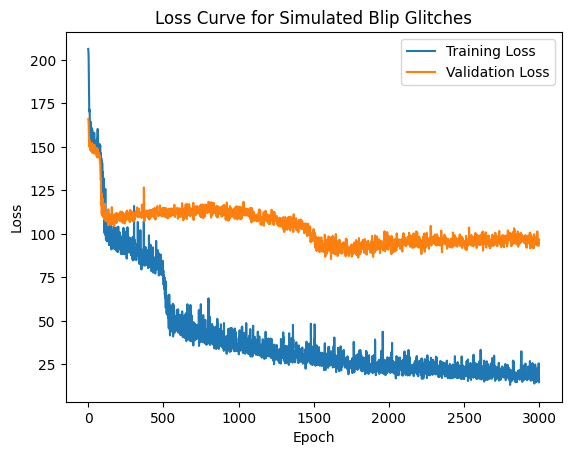

In [37]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Loss Curve for Simulated Blip Glitches")


In [15]:
test = autoencoder(X_test)
residual = X_test - test

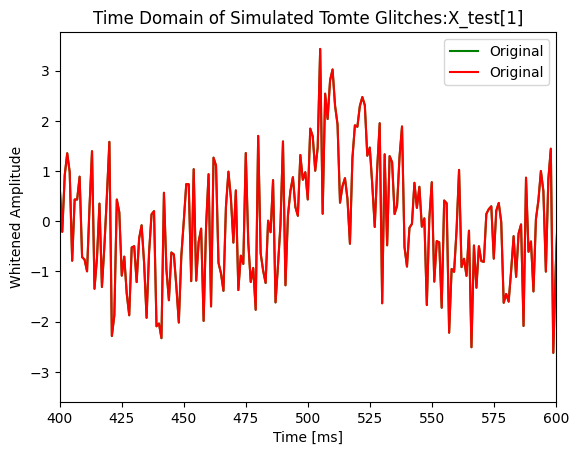

In [16]:
plt.plot(X_test[1], label='Original', color='green')
plt.plot(X_test[1], label='Original', color='red')
plt.xlim(400,600)
#plt.plot(test[5], label='Model', color='orange')
#plt.plot(residual[5], linestyle='dotted', color='black', label='Residual')
plt.xlabel("Time [ms]")
plt.ylabel("Whitened Amplitude")
plt.legend(loc='upper right')
plt.title("Time Domain of Simulated Tomte Glitches:X_test[1]")
plt.show()

In [ ]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 8)                 1690709   
                                                                 
 sequential_1 (Sequential)   (None, 1024)              1684149   
                                                                 
Total params: 3374858 (12.87 MB)
Trainable params: 3374858 (12.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
training_mean = X_train.mean()
training_std = X_train.std()
df_training_value = (X_train - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 600


In [ ]:
#autoencoder.load_weights("best_model.h5") # we load the best weights from the file

test_loss, test_acc = autoencoder.evaluate(X_test,  X_test) # we get the test loss and accuracy scores.
print(f'Test accuracy:{test_acc}, Test loss: {test_loss}')

13/13 [==============================] - 0s 5ms/step - loss: 0.2085 - accuracy: 0.8175
Test accuracy:0.8174999952316284, Test loss: 0.20846740901470184


In [24]:
test = autoencoder(X_test)
residual = X_test - test

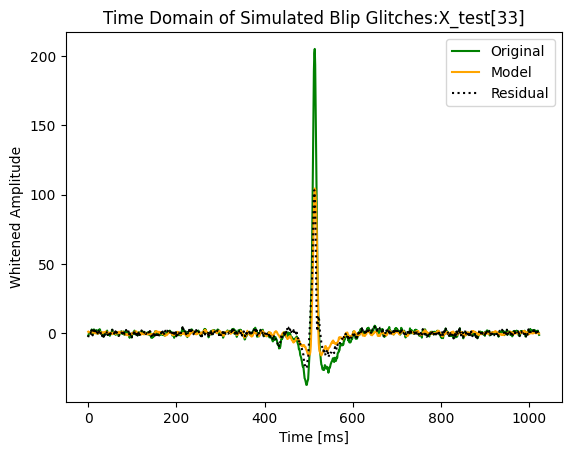

In [44]:
plt.plot(X_test[7], label='Original', color='green')
plt.plot(test[7], label='Model', color='orange')
plt.plot(residual[7], linestyle='dotted', color='black', label='Residual')
plt.xlabel("Time [ms]")
plt.ylabel("Whitened Amplitude")
plt.legend(loc='upper right')
plt.title("Time Domain of Simulated Blip Glitches:X_test[33]")
plt.show()

In [ ]:
X_train.shape


(600, 1024)

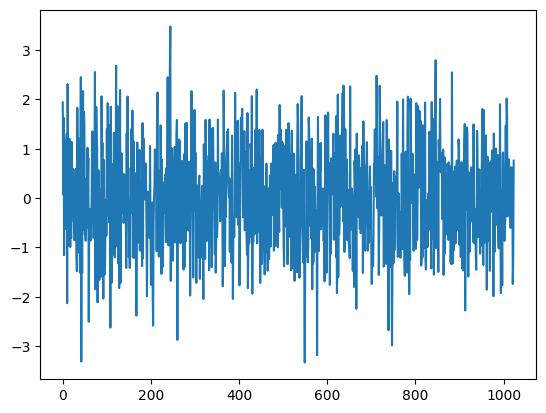

In [ ]:
plt.plot(data.whts)

(array([ 1.,  8., 21., 49., 58., 53., 33., 17.,  9.,  1.]),
 array([-3.30959627, -2.63116163, -1.95272699, -1.27429236, -0.59585772,
         0.08257692,  0.76101156,  1.4394462 ,  2.11788084,  2.79631548,
         3.47475012]),
 <BarContainer object of 10 artists>)

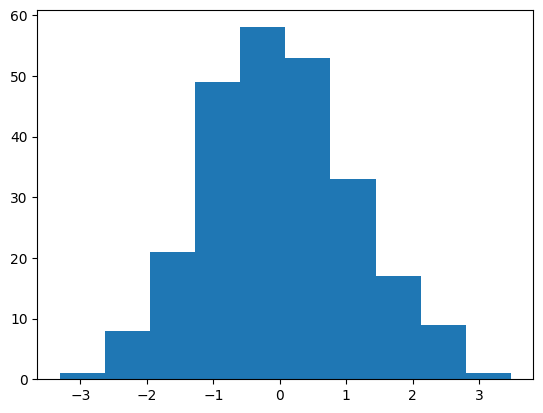

In [ ]:
plt.hist(data.whts[0:250])

In [ ]:
all_data.shape #training data

(1000, 1024)

In [ ]:
plt.np.var(X_train[:,:256])

1.0285295598195483

(array([ 2.,  6., 33., 56., 69., 68., 66., 30., 15.,  5.]),
 array([-2.98195695, -2.40474002, -1.82752308, -1.25030614, -0.67308921,
        -0.09587227,  0.48134466,  1.0585616 ,  1.63577854,  2.21299547,
         2.79021241]),
 <BarContainer object of 10 artists>)

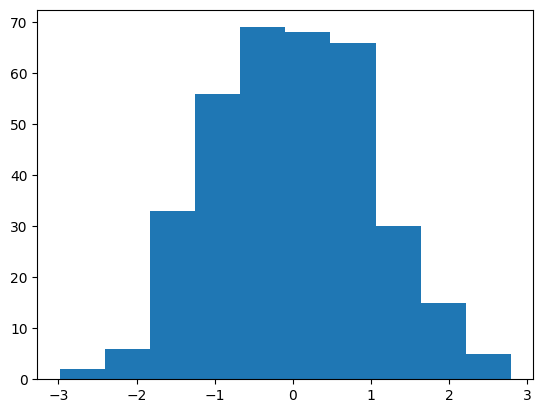

In [ ]:
plt.hist(data.whts[650:1000])

In [ ]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = X_train.mean()
training_std = X_train.std()
df_training_value = (X_train - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 80


In [ ]:
data = Snippet('/content/drive/MyDrive/Colab Notebooks/Project Notebooks/data2000/L1-tomte-0004.npz')



<ipython-input-5-ce0a007c1768>:17: RuntimeWarning: divide by zero encountered in power
  invasd = ((4096.*npz['psd'])**-0.5)[:4097]
<ipython-input-5-ce0a007c1768>:20: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  filt[:8192] = sig.hann(8192)*np.roll(irfft(invasd), 4096)
<ipython-input-5-ce0a007c1768>:7: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  tmp = np.abs(rfft(sig.hann(tlen)*np.roll(irfft(invasd), tlen//2)[:tlen]))


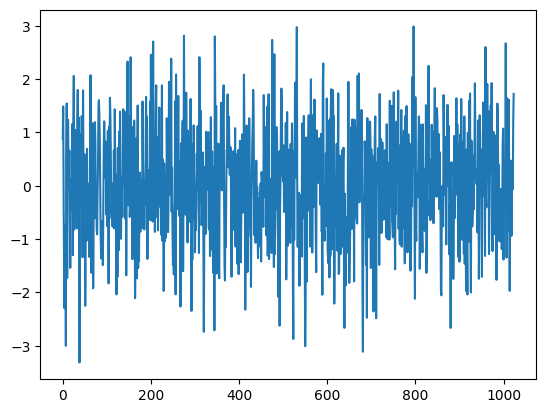

In [ ]:
plt.plot(data.whts)

In [ ]:
data.whts.shape

(1024,)

In [ ]:
 #data.keys()
data['data']

TypeError: 'Snippet' object is not subscriptable

In [ ]:

irfft = partial(irfft, norm='ortho')